In [1]:
# !pip install pandas
# !pip install pyarrow

# !pip install Pillow
# !pip install matplotlib
# !pip install scikit-learn
# !pip install torch
# !pip install tqdm
# !pip install ipdb
# !pip install sentencepiece
# !pip install tensorboard

In [2]:
from pathlib import Path
import os


# os.chdir("/root/workspace/mlx-week5/sid")
print(os.getcwd())
# root_path = Path(os.getcwd()).resolve().parents[0]
# print(root_path)
# os.chdir("/root/workspace/mlx44/src")
# os.mkdir(root_path / "workspace/mlx-week5")
# root = Path("/Users/sid/workspace/mlx-week5")
root = Path("/root/workspace/mlx-week5")
root.mkdir(exist_ok=True)
train_data_path = root / "train"
print(train_data_path)
os.chdir(root)

/
/root/workspace/mlx-week5/train


In [3]:
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import io
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import defaultdict
import numpy as np
import itertools as its
from tqdm import tqdm
import ipdb
from collections import namedtuple
from importlib import reload

In [56]:
# How to check is mps is available on my M1 MAC?
torch.backends.mps.is_available()
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
    # else ("mps" if torch.backends.mps.is_available() else "cpu")
)
device

device(type='cuda')

# Load the data from a single parquet file

In [5]:
# read a parquet file into a pandas dataframe
import pandas as pd
import pyarrow.parquet as pq

first_file = pd.read_parquet(train_data_path / "0000.parquet", engine="pyarrow")

In [6]:
all_sentences = first_file["text"].values
all_sentences = all_sentences.tolist()
all_sentences[0:5]

['One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.',
 'Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves that we

In [7]:
len(all_sentences), all_sentences[100]

(529930,
 "There was a little girl with dark hair. Her name was Joy. She lived in a big house with her parents. One day, Joy was playing outside in her garden. Suddenly, she felt something on her leg - something pinching her. It was a big, black bug! \n\nJoy screamed and tried to get away, but the bug kept following her. She tried to run and hide, but it was too quick. \n\nJoy's parents heard her cries and came running. They used a stick to help her get rid of the bug. After the bug was gone, they hugged Joy and told her everything would be alright. \n\nWhen the bug was gone, Joy felt relieved and happy. She went back to playing in the garden, making sure she didn't step on any more bugs.")

# Use sentence piece to tokenize the sentences

In [8]:
# Lets tokenize using sentence piece
from sentencepiece import SentencePieceTrainer, SentencePieceProcessor
import io

VOCAB_SIZE = 10000
SOS = "<SOS>"
EOS = "<EOS>"


# for article in articles[0:100]:
def get_data():
    for i in range(100):
        file = pd.read_parquet(
            train_data_path / f"{str(i).zfill(4)}.parquet", engine="pyarrow"
        )
        for sentence in file["text"].values:
            yield sentence


def get_model(train=False):
    model = io.BytesIO()
    model_filename = root / "models/tiny_stories_tokenizer.model"
    if train:
        SentencePieceTrainer.train(
            sentence_iterator=(story.lower() for story in all_sentences),
            model_writer=model,
            vocab_size=VOCAB_SIZE,
            user_defined_symbols=[SOS, EOS],
            # max_sentence_length=4196,
            # model_type="BPE",
        )
        sp_processor = SentencePieceProcessor(model_proto=model.getvalue())
    else:
        sp_processor = SentencePieceProcessor(model_file=str(model_filename))
    return sp_processor, model


def save_model(model):
    model_filename = root / "models/tiny_stories_tokenizer_2.model"
    with open(model_filename, "wb") as f:
        print(".")
        f.write(model.getvalue())

In [9]:
root

PosixPath('/root/workspace/mlx-week5')

In [10]:
sp_processor, model = get_model(train=False)

In [11]:
# EXECUTE ONCE WHEN YOU HAVE IT MADE
# save_model(model)

In [12]:
print(all_sentences[100])
print(".")
print(
    " ".join(
        [
            w
            for lst in sp_processor.encode_as_pieces(
                [story.lower() for story in all_sentences[100:101]]
            )
            for w in lst
        ]
    )
)
print("..")
print(sp_processor.encode_as_ids(all_sentences[100:101]))

There was a little girl with dark hair. Her name was Joy. She lived in a big house with her parents. One day, Joy was playing outside in her garden. Suddenly, she felt something on her leg - something pinching her. It was a big, black bug! 

Joy screamed and tried to get away, but the bug kept following her. She tried to run and hide, but it was too quick. 

Joy's parents heard her cries and came running. They used a stick to help her get rid of the bug. After the bug was gone, they hugged Joy and told her everything would be alright. 

When the bug was gone, Joy felt relieved and happy. She went back to playing in the garden, making sure she didn't step on any more bugs.
.
▁there ▁was ▁a ▁little ▁girl ▁with ▁dark ▁hair . ▁her ▁name ▁was ▁joy . ▁she ▁lived ▁in ▁a ▁big ▁house ▁with ▁her ▁parents . ▁one ▁day , ▁joy ▁was ▁playing ▁outside ▁in ▁her ▁garden . ▁suddenly , ▁she ▁felt ▁something ▁on ▁her ▁leg ▁- ▁something ▁pinching ▁her . ▁it ▁was ▁a ▁big , ▁black ▁bug ! ▁joy ▁screamed ▁and ▁

In [13]:
sp_processor.encode_as_pieces(
    "<SOS> hen the bug was gone, Joy felt relieved and happy. She went <EOS>"
)

# sp_processor.encode_as_ids("<SOS>en the bug was gone, Joy felt relieved and happy. She went <EOS>")
for sentence in all_sentences[100:110]:
    sentence = f"<SOS>{sentence.lower()}<EOS>"
    print(sp_processor.encode_as_pieces(sentence))
# sp_processor.encode_as_pieces("<SOS>hen the bug was gone, Joy felt relieved and happy. She went<EOS>")

['▁', '<SOS>', 'there', '▁was', '▁a', '▁little', '▁girl', '▁with', '▁dark', '▁hair', '.', '▁her', '▁name', '▁was', '▁joy', '.', '▁she', '▁lived', '▁in', '▁a', '▁big', '▁house', '▁with', '▁her', '▁parents', '.', '▁one', '▁day', ',', '▁joy', '▁was', '▁playing', '▁outside', '▁in', '▁her', '▁garden', '.', '▁suddenly', ',', '▁she', '▁felt', '▁something', '▁on', '▁her', '▁leg', '▁-', '▁something', '▁pinching', '▁her', '.', '▁it', '▁was', '▁a', '▁big', ',', '▁black', '▁bug', '!', '▁joy', '▁screamed', '▁and', '▁tried', '▁to', '▁get', '▁away', ',', '▁but', '▁the', '▁bug', '▁kept', '▁following', '▁her', '.', '▁she', '▁tried', '▁to', '▁run', '▁and', '▁hide', ',', '▁but', '▁it', '▁was', '▁too', '▁quick', '.', '▁joy', "'", 's', '▁parents', '▁heard', '▁her', '▁cries', '▁and', '▁came', '▁running', '.', '▁they', '▁used', '▁a', '▁stick', '▁to', '▁help', '▁her', '▁get', '▁rid', '▁of', '▁the', '▁bug', '.', '▁after', '▁the', '▁bug', '▁was', '▁gone', ',', '▁they', '▁hugged', '▁joy', '▁and', '▁told', '▁her'

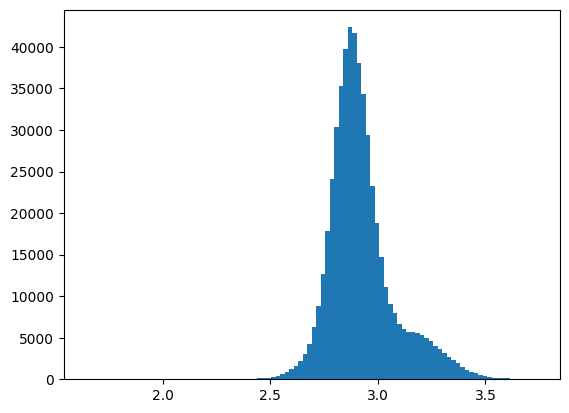

In [14]:
_ = plt.hist([np.log10(len(i)) for i in all_sentences if len(i) > 0], bins=100)

In [15]:
sentence_tokens = sp_processor.encode_as_ids(all_sentences[0:10000])

In [16]:
from collections import Counter

c = Counter(s for story in all_sentences[0:2000] for s in story.lower().split())

In [17]:
c.most_common(100)  #

[('the', 19446),
 ('and', 15380),
 ('to', 11073),
 ('a', 10305),
 ('was', 9370),
 ('he', 7614),
 ('she', 7045),
 ('they', 4960),
 ('it', 4864),
 ('her', 3894),
 ('in', 2947),
 ('his', 2923),
 ('so', 2905),
 ('with', 2632),
 ('of', 2603),
 ('had', 2327),
 ('that', 2185),
 ('but', 2071),
 ('little', 1853),
 ('one', 1806),
 ('very', 1771),
 ('for', 1765),
 ('there', 1690),
 ('you', 1653),
 ('on', 1598),
 ('said,', 1457),
 ('day,', 1445),
 ('once', 1408),
 ('saw', 1358),
 ('were', 1343),
 ('big', 1269),
 ('mom', 1246),
 ('wanted', 1214),
 ('upon', 1183),
 ('girl', 1162),
 ('all', 1144),
 ('is', 1137),
 ('not', 1103),
 ('lily', 1095),
 ('said', 1063),
 ('at', 987),
 ('happy', 984),
 ('when', 979),
 ('play', 961),
 ('went', 939),
 ('be', 929),
 ('i', 920),
 ('their', 905),
 ('time,', 888),
 ('up', 881),
 ('have', 876),
 ('are', 837),
 ('from', 823),
 ('looked', 809),
 ('go', 798),
 ('would', 773),
 ('could', 753),
 ('day', 751),
 ('felt', 734),
 ('can', 733),
 ('him', 731),
 ('it.', 727),
 (

# Data generation utilities

In [392]:
# Lets create a dataset
T = 512  # Window size
V = VOCAB_SIZE
B = 48
SOS = "<SOS>"
EOS = "<EOS>"


# This is a bit slow because it generates S*(N - T) samples of length T each, where S is the number of sentences and N is the number of tokens in the sentence
# TODO: If slow stupidly parallelize and load it into a numpy array and save it to a file, then memory map that file and load it into a torch tensor.
torch.manual_seed(42)


def data_generator(tokens):
    # xy = []  # x: T word window, y is T+1th word
    # Create a random minimatch
    ix = torch.randint(len(tokens) - T, (B,))
    x = [tokens[i : i + T] for i in ix]
    y = [tokens[i + 1 : i + T + 1] for i in ix]
    return x, y


x, y = data_generator(sp_processor.encode_as_ids(" ".join(all_sentences[2301:2340])))
print(len(x), len(x[1]), len(y), len(y[1]))

48 512 48 512


In [393]:
DATA_LIMIT = 4000
concatenated_sentences = " ".join(
    [f"<SOS>{sentence.lower()}<EOS>" for sentence in all_sentences[0:DATA_LIMIT]]
)
ids = sp_processor.encode_as_ids(concatenated_sentences)
all_data = []  # x, y pairs
for _ in tqdm(range(DATA_LIMIT)):
    x, y = list(data_generator(ids))
    for l1_x, l1_y in zip(x, y):
        all_data.append((l1_x, l1_y))

100%|██████████| 4000/4000 [00:03<00:00, 1203.06it/s]


In [394]:
print(len(all_data))
print(len(all_data[0]))
print(len(all_data[0][0]), len(all_data[0][1]))

192000
2
512 512


In [391]:
print(sp_processor.decode_ids(all_data[0][0]))
print(sp_processor.decode_ids(all_data[0][1]))

glad to be back safely with his friends. the superhero had rescued the cauliflower and made him very happy.<EOS> <SOS>once upon a time there was a cat who wanted to borrow some ink. he asked a big elephant and promised he would give it back. the elephant said yes and the cat was very happy. the elephant had an enormous bottle of ink. he was very kind and he let the cat borrow it. he gave it to the cat very carefully. the cat took the bottle back to his home. he was so happy. he asked a very small duck to help him carry the ink. they worked together and the cat was so glad! the cat filled his pen with the ink and he wrote a beautiful letter. he thanked the elephant for letting him borrow the ink. the cat was so happy and he never forgot the elephant's kindness. they were always friends after that.<EOS> <SOS>once upon a time, there was a mum and a dad who had a cute little boy. every day the family would go for a walk in the park. the sun was bright and the sky was blue. the little boy w

In [108]:
Dk**0.5

8.0

# The model

In [408]:
from itertools import chain

MAX_LEN_SEQ = 2000
N_EMBED = 512
Dk = 64
Dv = 64
V = VOCAB_SIZE
P_DROPOUT = 0.3
KEEP_BIAS = False

model_param_config = {
    "MAX_LEN_SEQ": MAX_LEN_SEQ,
    "N_EMBED": N_EMBED,
    "Dk": Dk,
    "Dv": Dv,
    "V": V,
    "P_DROPOUT": P_DROPOUT,
    "KEEP_BIAS": KEEP_BIAS,
    "T": T,
    "B": B,
}


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Create a long enough PE matrix beforehand
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        print("Pos Enc shape", pe.shape)
        # Register this pe matrix as a constant/static model parameter
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        # Add positional encoding
        x = x + self.pe[:, : x.size(1), :]
        return x


class SelfAttentionHead(nn.Module):
    def __init__(self, device):
        self.device = device
        super(SelfAttentionHead, self).__init__()
        self.Wq = nn.Linear(N_EMBED, Dk, bias=KEEP_BIAS)
        self.Wk = nn.Linear(N_EMBED, Dk, bias=KEEP_BIAS)
        self.Wv = nn.Linear(N_EMBED, Dv, bias=KEEP_BIAS)
        self.output_projection = nn.Linear(Dv, N_EMBED)
        self.residual_dropout = nn.Dropout(P_DROPOUT)

    def forward(self, x):
        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)
        self.q = q
        self.k = k
        a = torch.bmm(q, k.transpose(-2, -1)) / (Dk**0.5)
        self.a = a
        self.effective_T = a.shape[1]
        mask = torch.tril(
            torch.ones(self.effective_T, self.effective_T, device=self.device)
        )
        mask = mask.masked_fill(
            mask[: self.effective_T, : self.effective_T] == 0, float("-inf")
        )
        a = a + mask
        self.a_softmax = torch.functional.F.softmax(a, dim=-1)
        weighted_attention = self.a_softmax @ v
        return self.residual_dropout(self.output_projection(weighted_attention))


class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.c_fc = nn.Linear(N_EMBED, N_EMBED * 2)
        self.relu = nn.GELU()
        self.c_proj = nn.Linear(N_EMBED * 2, N_EMBED)
        self.dropout = nn.Dropout(P_DROPOUT)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.relu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):

    def __init__(self, device):
        super().__init__()
        self.ln_1 = nn.LayerNorm(N_EMBED)
        self.attn = SelfAttentionHead(device)
        self.ln_2 = nn.LayerNorm(N_EMBED)
        self.mlp = MLP()

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


# C = nn.Embedding(V, N_EMBED)
# The Query, Key and Value matrics for self attention
class TinyStoriesTransformer(nn.Module):
    def __init__(self, device):
        super(TinyStoriesTransformer, self).__init__()
        self.device = device
        self.C = nn.Embedding(V, N_EMBED)
        self.pos_encoder = PositionalEncoding(N_EMBED, MAX_LEN_SEQ)

        # self.bn = nn.BatchNorm1d(N_EMBED, track_running_stats=True)
        self.block = Block(device)
        # TODO(Sid): Add positional encoding and possibly 3 separate layers for a forward projection *before* passing to Wq, Wk and Wv

        # self.bn_after_ff = nn.BatchNorm1d(N_EMBED, track_running_stats=True)
        self.ln_ff = nn.LayerNorm(N_EMBED)
        # Softmax layer
        self.final_projection = nn.Linear(N_EMBED, V)

    def forward(self, x):
        x_embed = self.C(x)  # T * N_EMBED
        x_embed = x_embed * torch.sqrt(torch.tensor(N_EMBED).float())
        x_embed = self.pos_encoder(x_embed)

        # x_embed_permuted = x_embed.permute(0, 2, 1)  # N_EMBED * T
        # x_embed_normed = self.bn(x_embed_permuted)
        # x_embed_normed = x_embed_normed.permute(0, 2, 1)  # T * N_EMBED
        # Sublayer 1 and 2, i.e. the ATTENTION and MLP along with residual connections.
        x_sublayer_12 = self.block(x_embed)

        # Batch Norm
        # ff_output_permuted = x_sublayer_12.permute(0, 2, 1)
        # ff_output_normed = self.bn_after_ff(ff_output_permuted)
        # ff_output_normed = ff_output_normed.permute(0, 2, 1)

        layer_norm_output_final = self.ln_ff(
            x_sublayer_12
        )  # T * N_HIDDEN, Residual connection
        return self.final_projection(layer_norm_output_final)  # B * T * V

## Initialize the model

In [409]:
tiny_story_model = TinyStoriesTransformer(device)
tiny_story_model.to(device)

Pos Enc shape torch.Size([1, 2000, 512])


TinyStoriesTransformer(
  (C): Embedding(10000, 512)
  (pos_encoder): PositionalEncoding()
  (block): Block(
    (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (attn): SelfAttentionHead(
      (Wq): Linear(in_features=512, out_features=64, bias=False)
      (Wk): Linear(in_features=512, out_features=64, bias=False)
      (Wv): Linear(in_features=512, out_features=64, bias=False)
      (output_projection): Linear(in_features=64, out_features=512, bias=True)
      (residual_dropout): Dropout(p=0.3, inplace=False)
    )
    (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (mlp): MLP(
      (c_fc): Linear(in_features=512, out_features=1024, bias=True)
      (relu): GELU(approximate='none')
      (c_proj): Linear(in_features=1024, out_features=512, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
  )
  (ln_ff): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (final_projection): Linear(in_features=512, out_features=10000, bias=True)


In [410]:
# Quick test for shapes.
with torch.no_grad():
    tiny_story_model.eval()
    op = tiny_story_model(torch.randint(0, 10000, (B, T)).to(device))
    print(op.shape)

torch.Size([48, 512, 10000])


In [411]:
LEARNING_RATE = 0.001
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    tiny_story_model.parameters(),
    lr=LEARNING_RATE,
)
# for parameter_values in parameters:
#     for parameter in parameter_values:
#         print(".", end="")
#         parameter.requires_grad = True

# Over fit a batch 

In [364]:
def save_model(model, model_path, epoch, optimizer, loss, config):
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
            "config": config,
        },
        model_path,
    )


def load_model(model, model_path, optimizer):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    return model, optimizer, epoch, loss

In [135]:
device

device(type='cuda')

In [60]:
load_model(
    tiny_story_model, root / "model_overfitted_epoch_799_batch_799.pth", optimizer
)
tiny_story_model.to(device)

TinyStoriesTransformer(
  (C): Embedding(10000, 512)
  (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block): Block(
    (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (attn): SelfAttentionHead(
      (Wq): Linear(in_features=512, out_features=64, bias=True)
      (Wk): Linear(in_features=512, out_features=64, bias=True)
      (Wv): Linear(in_features=512, out_features=64, bias=True)
      (output_projection): Linear(in_features=64, out_features=512, bias=True)
      (residual_dropout): Dropout(p=0.5, inplace=False)
    )
    (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (mlp): MLP(
      (c_fc): Linear(in_features=512, out_features=1024, bias=True)
      (gelu): GELU(approximate='none')
      (c_proj): Linear(in_features=1024, out_features=512, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (bn_after_ff): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

## Validation loop logic

In [300]:
def validation_loop(model, test_dataloader, loss_fn):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_dataloader):

            # Forward pass
            z = model(x_batch.to(device))
            act = torch.softmax(z, dim=-1)  # B* T * V, where V is the
            # print(act.shape, y_sample.shape)

            act = act.view(-1, V)
            y_sample_view = y_batch.view(-1)

            loss = loss_fn(act, y_sample_view.to(device))

            # test_loss_values.append(loss.item())
            # print(loss.item())
            if torch.isnan(loss).any():
                print("NaN detected in test loss")

            total_loss += loss.item()
    return total_loss / (i + 1)

## Create a small batch

In [316]:
print(len(all_data))

768000


In [399]:
n_train = int(len(all_data) * 0.9)
train_data = all_data[0:n_train]
test_data = all_data[n_train:]
X_train = torch.tensor([i[0] for i in train_data])
Y_train = torch.tensor([i[1] for i in train_data])
X_test = torch.tensor([i[0] for i in test_data])
Y_test = torch.tensor([i[1] for i in test_data])

In [400]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    list(zip(X_train, Y_train)),
    batch_size=B,
    shuffle=True,
)
test_dataloader = DataLoader(
    list(zip(X_test, Y_test)),
    batch_size=B,
    shuffle=True,
)

In [401]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([172800, 512]),
 torch.Size([172800, 512]),
 torch.Size([19200, 512]),
 torch.Size([19200, 512]))

In [39]:
# Set a seed for numpy
np.random.seed(99999999)
# random_idx = np.random.randint(0, X_train.shape[0], 2000)
random_idx = np.arange(0, 200)
print(random_idx.shape)
X_batch, Y_batch = X_train[random_idx, :].to(device), Y_train[random_idx, :].to(device)
print(X_batch.shape, Y_batch.shape)

(200,)
torch.Size([200, 100]) torch.Size([200, 100])


In [299]:
for i, (l, m) in enumerate(test_dataloader):
    print(l.to(device), m.to(device))

tensor([[   8,   16,  365,  ...,    6,  582,   11],
        [   7,  329,   11,  ...,    9,  283,    6],
        [  26,   13,  273,  ...,    5,   13,   82],
        ...,
        [  12,  105,  175,  ...,   64,    8,   14],
        [  28,    8,   25,  ...,    8,   79,    8],
        [  53,   72,    8,  ...,    7, 1008,    5]], device='cuda:0') tensor([[  16,  365,   23,  ...,  582,   11,  114],
        [ 329,   11,  114,  ...,  283,    6, 1089],
        [  13,  273,   61,  ...,   13,   82,    9],
        ...,
        [ 105,  175,   14,  ...,    8,   14,   11],
        [   8,   25,   18,  ...,   79,    8,   46],
        [  72,    8,  327,  ..., 1008,    5,   93]], device='cuda:0')
tensor([[  40,    8,   37,  ...,  142,   21, 2198],
        [ 216,    5,   23,  ...,   22,  322,    9],
        [   8,   13,  185,  ...,   95,   44,   83],
        ...,
        [ 377,    7,   88,  ...,    5,   15,  105],
        [   4,   69,    3,  ...,  109,  774,  293],
        [ 390,   18,   22,  ...,  124,  5

## Model training loop

In [412]:
train_loss_values = []

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir="./logs")

In [413]:
n_epochs = 800
epochs_iter = iter(range(1, n_epochs))

In [414]:
tiny_story_model.train()
with tqdm(total=n_epochs, desc="Epochs", leave=False) as progress_bar:
    for epoch in epochs_iter:
        n_batches = 0
        for X_batch, Y_batch in tqdm(train_dataloader, desc="Batches", leave=False):
            optimizer.zero_grad()
            z = tiny_story_model(X_batch.to(device))
            act = torch.softmax(z, dim=-1)  # B* T * V, where V is the
            # print(act.shape, y_sample.shape)

            act = act.view(-1, V)
            y_sample_view = Y_batch.view(-1)

            loss = ce_loss(act, y_sample_view.to(device))

            train_loss_values.append(loss.item())

            if epoch % 10 == 0 or n_batches % 10 == 0:
                # validation_loss = validation_loop(tiny_story_model, test_dataloader, ce_loss)
                validation_loss = 0
                # print(".", end="")
                progress_bar.set_description(
                    f"Epoch [{epoch}/{n_epochs}], Batch {n_batches}], Loss: {np.round(loss.item(), decimals=4)}, Val Loss {np.round(validation_loss, decimals=4)}, Last 5 losses: {', '.join([str(np.round(i, decimals=4)) for i in train_loss_values[-5:]])}"
                )

            # print(loss.item())
            loss.backward()
            with torch.no_grad():
                for name, param in tiny_story_model.named_parameters():
                    if param.requires_grad and param.grad is not None:
                        writer.add_scalar(
                            f"grad_norm/{name}", param.grad.norm(), n_batches
                        )

            optimizer.step()
            del z
            del act
            n_batches += 1
        if epoch % 799 == 0:
            save_model(
                tiny_story_model,
                f"model_overfitted_epoch_{(epoch)}_batch_{(epoch)}.pth",
                epoch,
                optimizer,
                loss,
            )

    # Cross entropy between the output of the FF layer_norm_output_final and the target y
    # print(act.shape)

Epoch [2/800], Batch 130], Loss: 9.0139, Val Loss 0, Last 5 losses: 9.0173, 9.0077, 9.0099, 9.0105, 9.0139:   0%|          | 0/800 [11:46<?, ?it/s] 

In [386]:
save_model(
    tiny_story_model,
    f"best_transform_model_more_dropout_made_things_better.pth",
    epoch,
    optimizer,
    loss,
    model_param_config,
)

In [362]:
validation_loop(tiny_story_model, test_dataloader, ce_loss)

8.997580370903016

In [47]:
del tiny_story_model

NameError: name 'tiny_story_model' is not defined

In [119]:
import gc

gc.collect()
torch.cuda.empty_cache()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


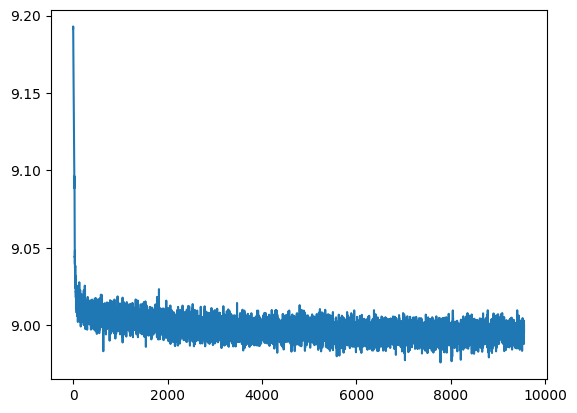

In [367]:
ax = plt.plot(train_loss_values[9050:])

In [368]:
trained_Xs = X_batch.detach().cpu().numpy()
trained_Xs = trained_Xs.tolist()
print(len(trained_Xs))
sp_processor.decode_ids(trained_Xs)

192


['have fun in the yard. they are happy.<EOS> <SOS>sara liked to play with her dolls in the park. she had many dolls and she gave them names and clothes. she was happy when she played with her dolls. one day, a boy came to the park. he had a big truck and he made',
 'at the top, the gentle spider noticed the most amazing view! she was so happy that she had asked her question. she stayed a while and enjoyed the beautiful sight. then she smiled, and slowly climbed back down the tree. she could now answer the question she had asked. the gentle spider was very proud!<EOS>',
 "around but without luck. he was so upset he couldn't enjoy the wild outdoor adventures anymore. one day, he was walking along a street and he heard something strange - it was the sound of his little red wagon! the little boy raced towards the sound and there, to his surprise and delight, was his wagon",
 'loved exploring new places. one day, she went to a park and found a violin. she had never seen one before, so she p

# Inference 

In [ ]:
device = "cpu"
tiny_story_model.to(device)

In [377]:
# grab a random token and make the network generate things
# def generate_text(model, sp_processor, test_sentence):
test_sentence = "sara liked to play with her toys"
tiny_story_model.eval()
# token = torch.randint(0, V, (1, 1)).to(device)
tokens = sp_processor.encode_as_ids(f"<SOS>{test_sentence}")
# print(tokens)
generated_text = []

torch_tokens = torch.tensor([tokens]).to(device)
prev_tokens = torch_tokens
# print(tokens.shape)
distributions_acts = []
max_probs_lst = []

temperature = 0.9  # Adjust this parameter to control diversity

for i in range(50):
    with torch.no_grad():
        z = tiny_story_model(prev_tokens)
        scaled_z = z / temperature
        probs = torch.softmax(scaled_z, dim=-1)
        # distributions_acts.append(act)
        probs = probs.view(-1, V)  # len(generated_tokens) +i * V
        sampled_token = torch.multinomial(probs[-1, :], num_samples=2)
        print(sampled_token)

        # max_probs, max_idxs = torch.max(probs, dim=-1)
        # max_probs_lst.append(probs[-1, sampled_token])

        # print(int(sampled_token), int(max_probs[-1]))
        # print(".")
        generated_text.append(int(sampled_token[0]))

        prev_tokens = torch.cat(
            (prev_tokens, torch.tensor([[sampled_token[0]]], device=device)), dim=1
        )
decoded_text = sp_processor.decode_ids(generated_text)

print(test_sentence + " [" + decoded_text + " ]")

tensor([ 5, 41], device='cuda:0')
tensor([12,  9], device='cuda:0')
tensor([11, 19], device='cuda:0')
tensor([10, 18], device='cuda:0')
tensor([ 45, 121], device='cuda:0')
tensor([ 8, 17], device='cuda:0')
tensor([ 16, 216], device='cuda:0')
tensor([108, 808], device='cuda:0')
tensor([18, 29], device='cuda:0')
tensor([ 22, 114], device='cuda:0')
tensor([  5, 808], device='cuda:0')
tensor([ 12, 142], device='cuda:0')
tensor([11, 16], device='cuda:0')
tensor([10, 18], device='cuda:0')
tensor([45, 18], device='cuda:0')
tensor([ 8, 17], device='cuda:0')
tensor([ 16, 216], device='cuda:0')
tensor([108, 808], device='cuda:0')
tensor([18, 29], device='cuda:0')
tensor([ 22, 114], device='cuda:0')
tensor([  5, 808], device='cuda:0')
tensor([12, 96], device='cuda:0')
tensor([11, 81], device='cuda:0')
tensor([10, 18], device='cuda:0')
tensor([ 45, 121], device='cuda:0')
tensor([ 8, 17], device='cuda:0')
tensor([16,  8], device='cuda:0')
tensor([108, 808], device='cuda:0')
tensor([18, 29], device=

In [34]:
probs.shape

torch.Size([11, 10000])

In [400]:
for t, p in zip(generated_text, max_probs_lst):
    print(sp_processor.decode(t), float(p), end=", ")

Once 0.9999822378158569, upon 0.9999823570251465, a 0.9999864101409912, little 0.9999864101409912, girl 0.9999818801879883, named 0.9999959468841553, Beep 0.9999864101409912, loved 0.9999868869781494, to 0.9794060587882996, go 0.9999847412109375, fast 0.9999902248382568, and 0.999988317489624, said 0.9999850988388062, , 0.9999988079071045, " 0.9879357814788818, Mom 0.9999853372573853, , 0.9999943971633911, " 0.990085244178772, Mom 0.9520663619041443, , 0.9999943971633911, " 0.9918128252029419, Mom 0.8985897898674011, , 0.9999943971633911, " 0.993184506893158, Mom 0.8695441484451294, , 0.9999943971633911, " 0.9942948222160339, Mom 0.851822018623352, , 0.9999943971633911, " 0.9951932430267334, Mom 0.8400238156318665, , 0.9999943971633911, " 0.9959267973899841, Mom 0.8316372632980347, , 0.9999943971633911, " 0.9965178966522217, Mom 0.82539302110672, , 0.9999943971633911, " 0.9970095157623291, Mom 0.820560097694397, , 0.9999943971633911, " 0.9974110722541809, Mom 0.81671142578125, , 0.9999

484800 960000
[9.45084253e-07 8.04790375e-06 1.13667030e-03 9.25837986e-02
 3.77411470e-01]


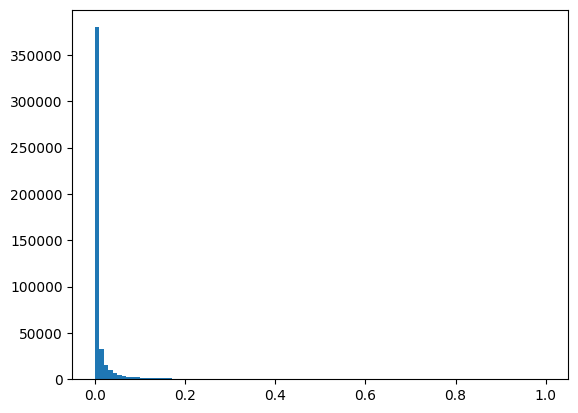

In [105]:
ax = plt.subplot()
vals = tiny_story_model.block.attn.a_softmax.view(-1).detach().to("cpu").numpy()
print(np.count_nonzero(vals), len(vals))
non_zeros = vals[np.where(vals != 0)]
print(np.quantile(non_zeros, [0.01, 0.05, 0.5, 0.95, 0.99]))
_ = ax.hist(non_zeros, bins=100)

In [132]:
# Example of target with class indices
random_loss = nn.CrossEntropyLoss()
input = torch.tensor(
    [
        [
            [0.9, 5.8, 0.2, -0.65, 0.3],
            [0.9, -1.8, 0.2, 0.65, 7.3],
            [10.9, -1.8, 0.2, -0.65, 0.3],
        ],
        [
            [0.9, 5.8, 0.2, -0.65, 0.3],
            [0.9, -1.8, 0.2, 0.65, 7.3],
            [10.9, -1.8, 0.2, -0.65, 0.3],
        ],
    ],
    requires_grad=True,
)
target = torch.tensor([[1, 4, 0], [2, 1, 1]], dtype=torch.long)
print(input.shape, target.shape)
print(input, target)
input_view = input.view(-1, 5)
target_view = target.view(-1)
print(input_view.shape, target_view.shape)
print(input_view, target_view)
print(".")
output = random_loss(input_view, target_view)
print(output)
# output.backward()
# # Example of target with class probabilities
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5).softmax(dim=1)
# output = loss(input, target)
# output.backward()

torch.Size([2, 3, 5]) torch.Size([2, 3])
tensor([[[ 0.9000,  5.8000,  0.2000, -0.6500,  0.3000],
         [ 0.9000, -1.8000,  0.2000,  0.6500,  7.3000],
         [10.9000, -1.8000,  0.2000, -0.6500,  0.3000]],

        [[ 0.9000,  5.8000,  0.2000, -0.6500,  0.3000],
         [ 0.9000, -1.8000,  0.2000,  0.6500,  7.3000],
         [10.9000, -1.8000,  0.2000, -0.6500,  0.3000]]], requires_grad=True) tensor([[1, 4, 0],
        [2, 1, 1]])
torch.Size([6, 5]) torch.Size([6])
tensor([[ 0.9000,  5.8000,  0.2000, -0.6500,  0.3000],
        [ 0.9000, -1.8000,  0.2000,  0.6500,  7.3000],
        [10.9000, -1.8000,  0.2000, -0.6500,  0.3000],
        [ 0.9000,  5.8000,  0.2000, -0.6500,  0.3000],
        [ 0.9000, -1.8000,  0.2000,  0.6500,  7.3000],
        [10.9000, -1.8000,  0.2000, -0.6500,  0.3000]],
       grad_fn=<ViewBackward0>) tensor([1, 4, 0, 2, 1, 1])
.
tensor(4.5735, grad_fn=<NllLossBackward0>)
